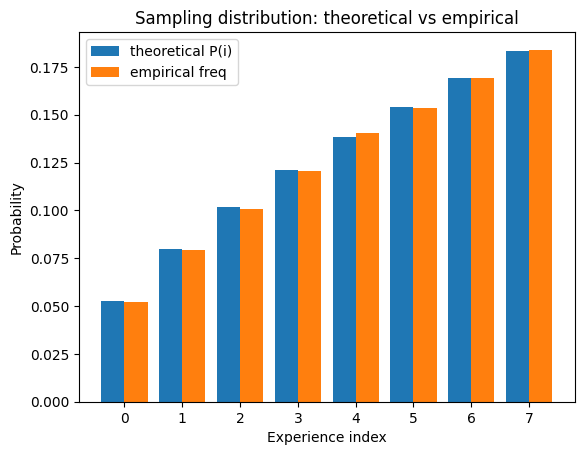

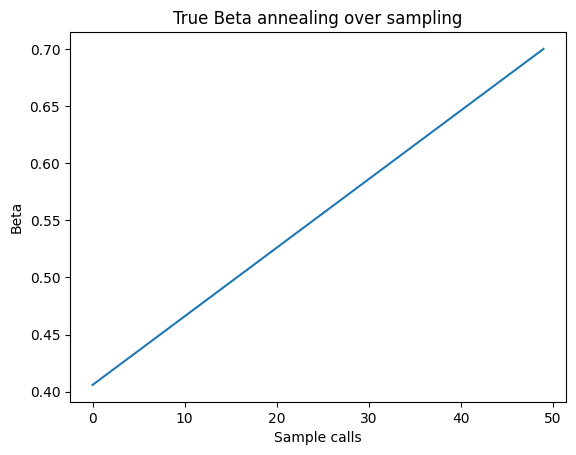

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define SumTree and PrioritizedReplayBuffer classes
class SumTree:
    def __init__(self, capacity):
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)
        self.data = np.zeros(capacity, dtype=object)
        self.write = 0
        self.n_entries = 0

    def add(self, data, priority):
        tree_index = self.write + self.capacity - 1
        self.data[self.write] = data
        self.update(tree_index, priority)
        self.write = (self.write + 1) % self.capacity
        if self.n_entries < self.capacity:
            self.n_entries += 1

    def update(self, tree_index, priority):
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change

    def get(self, value):
        parent_idx = 0
        while True:
            left = 2 * parent_idx + 1
            right = left + 1
            if left >= len(self.tree):
                break
            if value <= self.tree[left]:
                parent_idx = left
            else:
                value -= self.tree[left]
                parent_idx = right
        data_idx = parent_idx - self.capacity + 1
        return parent_idx, self.tree[parent_idx], self.data[data_idx]

    def total(self):
        return self.tree[0]

    def __len__(self):
        return self.n_entries

class PrioritizedReplayBuffer:
    def __init__(self, capacity, alpha=0.6, beta0=0.4, beta_steps=1000, epsilon=1e-6):
        self.tree = SumTree(capacity)
        self.capacity = capacity
        self.alpha = alpha
        self.beta = beta0
        self.beta0 = beta0
        self.beta_inc = (1.0 - beta0) / beta_steps
        self.epsilon = epsilon
        self.max_prio = 1.0

    def add(self, experience):
        p = (self.max_prio + self.epsilon) ** self.alpha
        self.tree.add(experience, p)

    def sample(self, batch_size):
        batch, idxs, ps = [], [], []
        total = self.tree.total()
        segment = total / batch_size
        for i in range(batch_size):
            a, b = segment * i, segment * (i + 1)
            s = np.random.uniform(a, b)
            idx, p, data = self.tree.get(s)
            batch.append(data)
            idxs.append(idx)
            ps.append(p)
        ps = np.array(ps) / total
        N = len(self.tree)
        weights = (N * ps) ** (-self.beta)
        weights /= weights.max()
        self.beta = min(1.0, self.beta + self.beta_inc)
        return batch, idxs, weights

    def update_priorities(self, idxs, errors):
        for idx, err in zip(idxs, errors):
            p = (abs(err) + self.epsilon) ** self.alpha
            self.tree.update(idx, p)
            self.max_prio = max(self.max_prio, p)

# Instantiate buffer and add deterministic experiences
capacity = 8
buffer = PrioritizedReplayBuffer(capacity=capacity, alpha=0.6, beta0=0.4, beta_steps=100)

for i in range(capacity):
    # let experience be its index, set initial prio increasing
    buffer.tree.add(f"exp_{i}", priority=(i+1)**buffer.alpha)

# Theoretical probabilities
priorities = np.array([buffer.tree.tree[i + capacity - 1] for i in range(capacity)])
theoretical_p = priorities / priorities.sum()

# Sample many times
samples = []
for _ in range(20000):
    batch, idxs, _ = buffer.sample(1)
    samples.append(idxs[0] - (capacity-1))

samples = np.array(samples)
counts = np.bincount(samples, minlength=capacity)
empirical_p = counts / counts.sum()

# Plot theoretical vs empirical
fig, ax = plt.subplots()
indices = np.arange(capacity)
ax.bar(indices - 0.2, theoretical_p, width=0.4, label='theoretical P(i)')
ax.bar(indices + 0.2, empirical_p, width=0.4, label='empirical freq')
ax.set_xlabel('Experience index')
ax.set_ylabel('Probability')
ax.set_title('Sampling distribution: theoretical vs empirical')
ax.legend()
plt.show()


# Reinstantiate buffer for a clean beta-annealing demonstration
buffer = PrioritizedReplayBuffer(capacity=8, alpha=0.6, beta0=0.4, beta_steps=100, epsilon=1e-6)

# Populate with dummy experiences so sample() can draw
for i in range(buffer.capacity):
    buffer.tree.add(f"exp_{i}", priority=(i+1)**buffer.alpha)

# Collect beta values over 50 fresh sample calls
betas = []
for _ in range(50):
    _batch, _idxs, _weights = buffer.sample(1)
    betas.append(buffer.beta)

# Plot the true annealing curve
fig, ax = plt.subplots()
ax.plot(betas)
ax.set_xlabel('Sample calls')
ax.set_ylabel('Beta')
ax.set_title('True Beta annealing over sampling')
plt.show()
